# Intensity Interferometry

Consider a pair of detectors, $a$ and $b$, measuring the intensity of a common (extended) source of light. The time correlation of both signals provides information on the spatial distribution of the source.

$$\left<I_a(t)I_b(t)\right>_{\tau}=\frac{1}{\tau}\int_t^{t+\tau}\mathrm{d}t'I_a(t')I_b(t'),$$

where $\tau$ is the integration time of the correlator.

Denoting $\mathbf{r}$ the baseline--the relative distance between a pair of detectors--the intensity correlation can be written:

$$\left<I_a(t)I_b(t)\right>_{\tau}(\mathbf{r}) = \left<I_a\right>\left<I_b\right>(1+\left|\gamma_{12}(\mathbf{r})\right|^2),$$

where $\gamma_{12}(\textbf{r})$ is directly related to the Fourier transform of the source density distribution.

Here, we investigate the signal measured observed for an elliptic source, using a pair of telescope with an arbitrary baseline.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import importlib
import II
from II import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm

In [4]:
ls = II.LightSource(shape='ellipse')
uv = II.UVplane(ls)

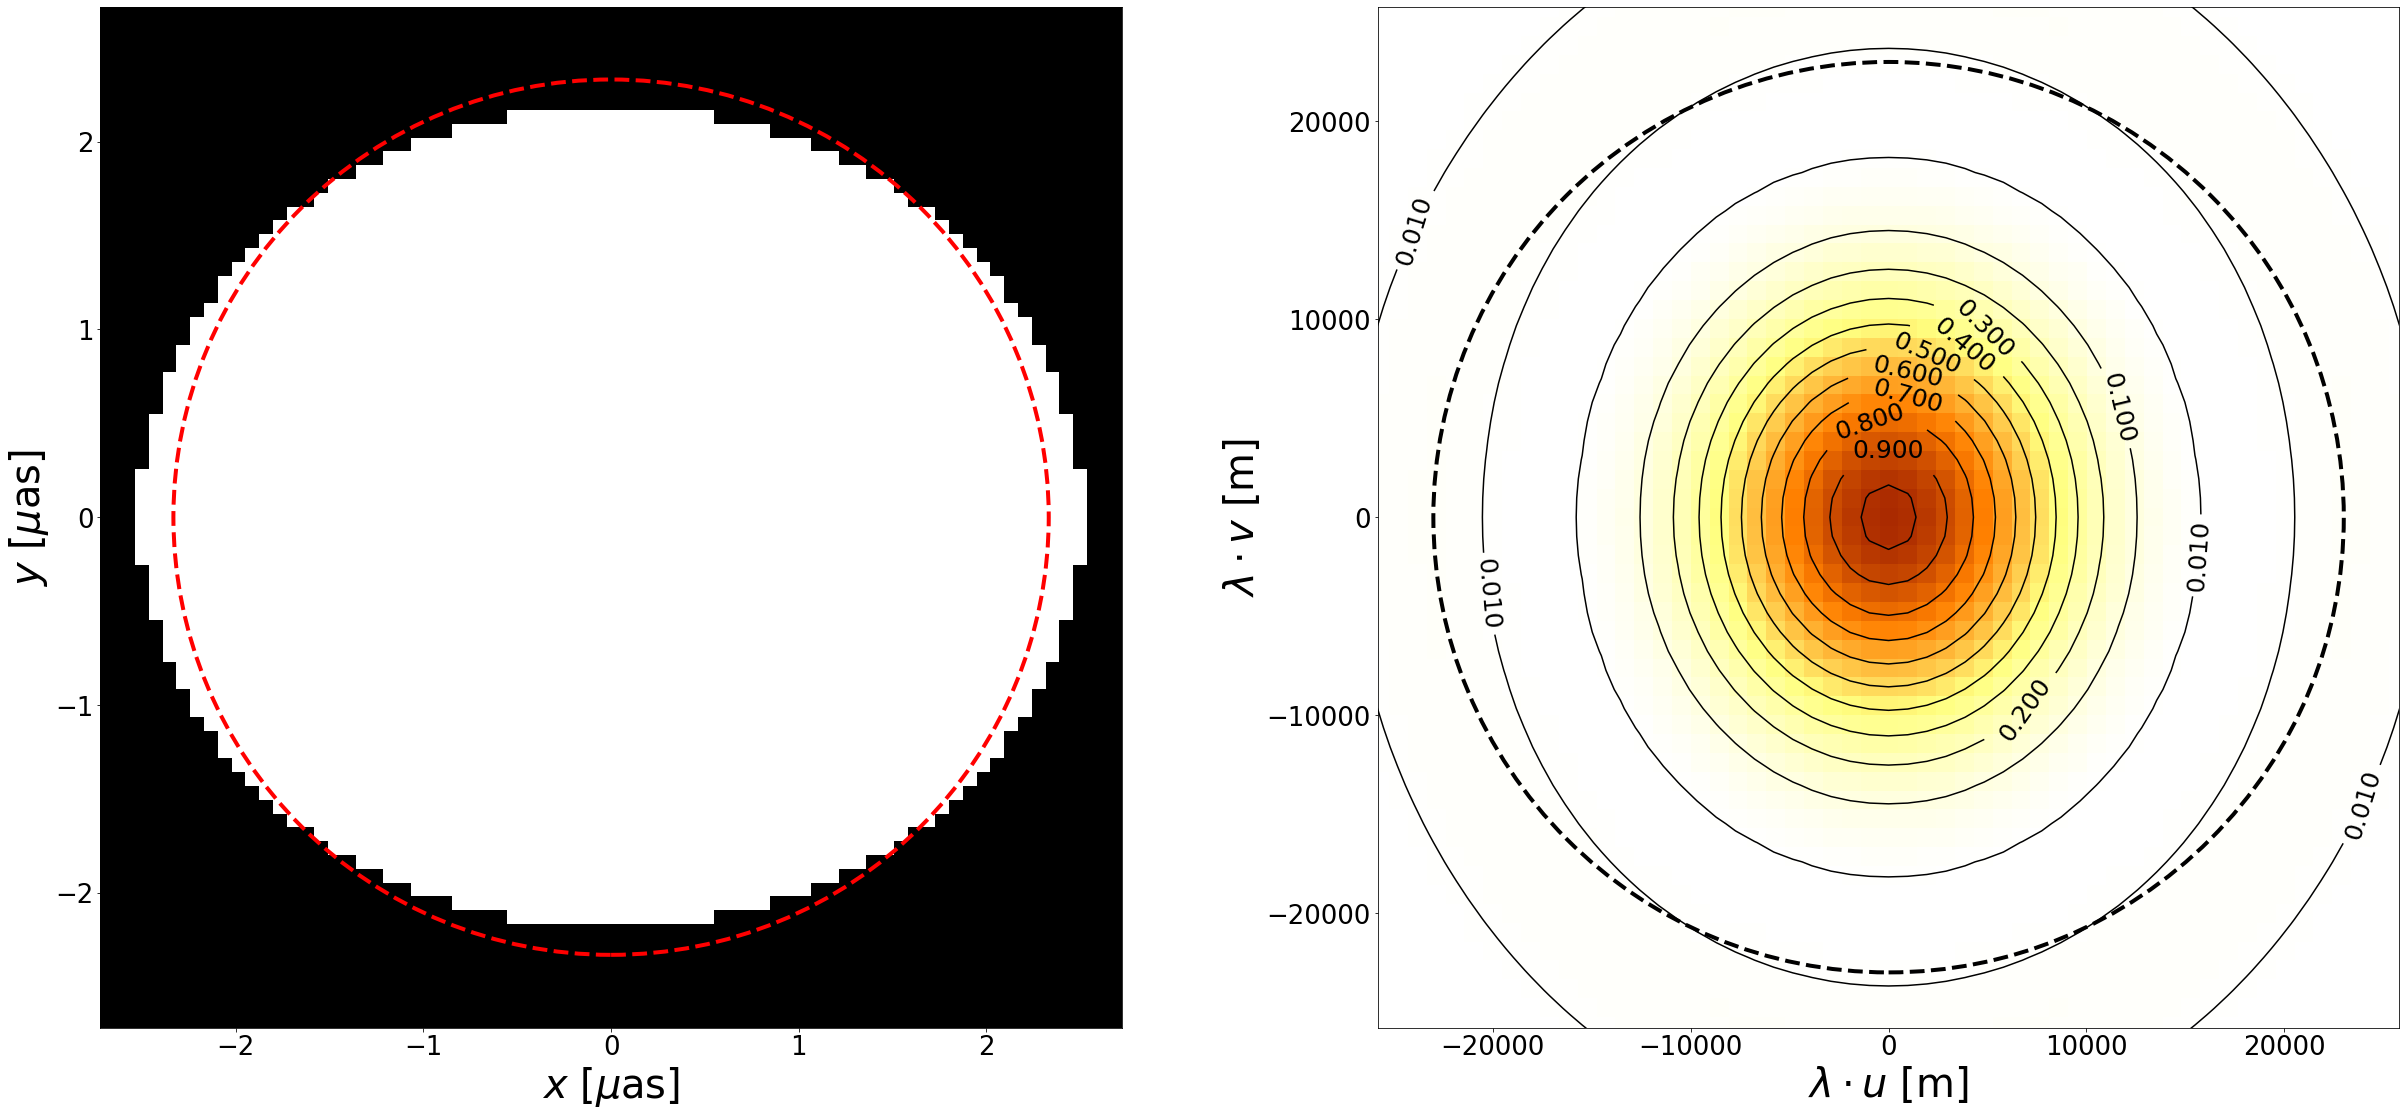

In [5]:
uv.plotSource()

In [16]:
cta = II.TelescopeArray(uv,layout='layouts/basic_cta', nGrid=64, nPerTraj=128)

0 0 layouts/basic_cta/23m_telescope.csv layouts/basic_cta/23m_telescope.csv
0 1 layouts/basic_cta/12m_telescope.csv layouts/basic_cta/23m_telescope.csv
1 1 layouts/basic_cta/12m_telescope.csv layouts/basic_cta/12m_telescope.csv
0 2 layouts/basic_cta/04m_telescope.csv layouts/basic_cta/23m_telescope.csv
1 2 layouts/basic_cta/04m_telescope.csv layouts/basic_cta/12m_telescope.csv
2 2 layouts/basic_cta/04m_telescope.csv layouts/basic_cta/04m_telescope.csv


In [17]:
cta.setGrids()

Computing SNR grid:


Pairs (4.0-4.0): 100%|██████████| 2379/2379 [00:34<00:00, 68.30it/s]
/net/cephfs/home/hlasco/intensity_interferrometry_layout_benchmark/II.py:366: RuntimeWarning: invalid value encountered in true_divide
  areaGrid = np.where(nInGrid == 0, 0, areaGrid / nInGrid)


In [162]:
def plotSNR(detector):
    x = np.linspace(-detector.bline_max, detector.bline_max, detector.N_snr_grid)
    y = np.linspace(-detector.bline_max, detector.bline_max, detector.N_snr_grid)
    xx, yy = np.meshgrid(x, y)
    snr = detector.getSNRGrid()
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx ,yy , snr.T, norm=LogNorm())
    plt.colorbar()

<ipython-input-28-623c5a87c991>:6: RuntimeWarning: invalid value encountered in true_divide
  sigma = np.fabs(signal2 / (snr * np.sqrt(nNights)))


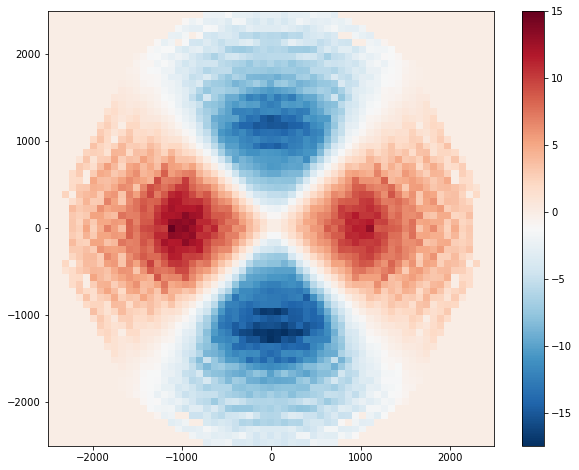

In [28]:
nNights = 100000
signal1, _ = cta.getSignal(nNights = nNights, phi_source = np.pi/2, bNoise=False)
signal2, std = cta.getSignal(nNights = nNights, phi_source = 0, bNoise=True)

s = (signal1 - signal2)
sigma = np.fabs(signal2 / (snr * np.sqrt(nNights)))
data = s/sigma
mask = (snr<1e-4)
data[mask] = 0

plt.figure(figsize=(10, 8))
plt.pcolormesh(xx ,yy ,(data.T), cmap='RdBu_r')#, vmin=-100, vmax=100)
plt.colorbar()

In [160]:
import emcee

def log_likelihood(phi, detector, signal, time, std):
    model, _ = detector.getSignal(nNights = time, phi_source = phi, bNoise=False)
    mask = (std > 0 )
    
    obs = signal[mask]
    exp = model[mask]
    std_ = std[mask]
    
    ret =  -.5*np.sum((obs - exp)**2 / std_**2 + np.log(2*np.pi*std_**2))
    return ret

def log_prior(phi): #prior for rp is flat around rp_true with + and - 20x error on rp_true
    phi_range = -np.pi/4 < phi < np.pi/4
    if phi_range:
        return 0.0
    return -np.inf

def log_probability(phi, detector, signal, time, std):
    lp = log_prior(phi)
    return lp + log_likelihood(phi, detector, signal, time, std)

def run_mcmc(detector, time, phi_source, n_walkers=4, steps=1000):
    pos = np.array([[np.random.uniform(-np.pi/4, np.pi/4)] for k in range(n_walkers)])
    nwalkers, ndim = pos.shape
    signal, _ = detector.getSignal(nNights = time, phi_source = phi_source, bNoise=True)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(detector, signal, time, std))
    sampler.run_mcmc(pos, steps, progress=True)

    return sampler

In [133]:
def run_benchmark(detector, time, phi_source, steps, n_walkers):
    #detector.setGrids()
    sampler = run_mcmc(detector, time=time, phi_source=phi_source, n_walkers = n_walkers, steps=steps)
    return sampler

In [166]:
detector1 = II.TelescopeArray(uv,layout='layouts/cta_only_04m/', nGrid=64, nPerTraj=128)
detector1.setGrids()
detector2 = II.TelescopeArray(uv,layout='layouts/basic_cta/', nGrid=64, nPerTraj=128)
detector2.setGrids()

Computing SNR grid from layout: layouts/cta_only_04m/


Pairs (4.0-4.0): 100%|██████████| 2379/2379 [01:01<00:00, 38.50it/s]
/net/cephfs/home/hlasco/intensity_interferrometry_layout_benchmark/II.py:365: RuntimeWarning: invalid value encountered in true_divide
  areaGrid = np.where(nInGrid == 0, 0, areaGrid / nInGrid)


Computing SNR grid from layout: layouts/basic_cta/


Pairs (4.0-4.0): 100%|██████████| 2379/2379 [00:47<00:00, 49.61it/s]


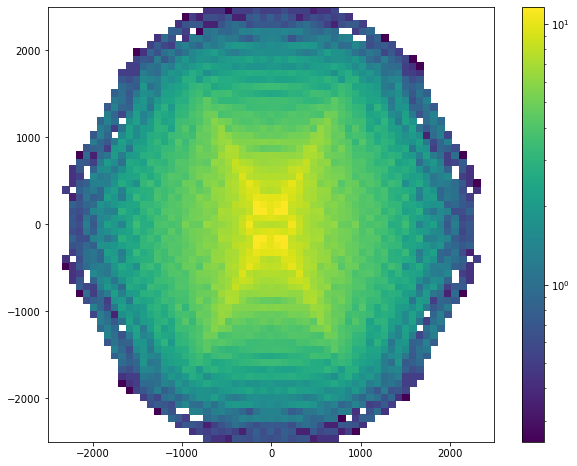

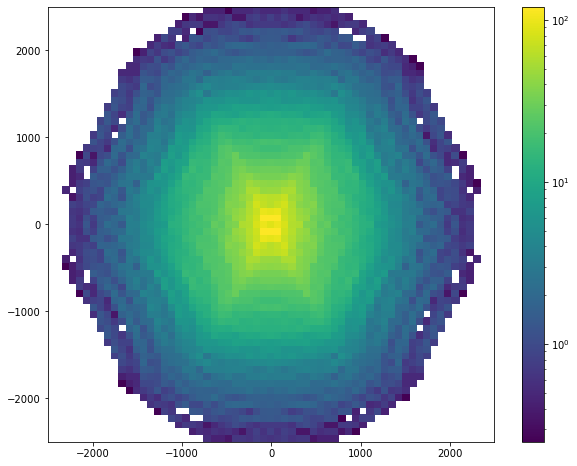

In [167]:
plotSNR(detector1)
plotSNR(detector2)

In [169]:
sampler1 = run_benchmark(detector1, time=10, phi_source=0, steps=100, n_walkers=8)
sampler2 = run_benchmark(detector2, time=10, phi_source=0, steps=100, n_walkers=8)

100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


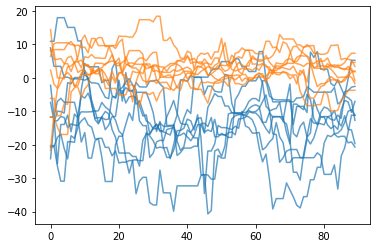

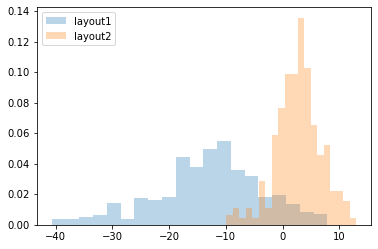

In [172]:
samples1 = sampler1.get_chain(discard=10)
samples2 = sampler2.get_chain(discard=10)


plt.plot(samples1[:,:,0]*180/np.pi, alpha=0.7, color='C0')
plt.plot(samples2[:,:,0]*180/np.pi, alpha=0.7, color='C1')
plt.show()

flat_samples1 = sampler1.get_chain(discard=50, thin=1, flat=True)
flat_samples2 = sampler2.get_chain(discard=50, thin=1, flat=True)
h1 = plt.hist(flat_samples1*180/np.pi, bins=bins, density=True, alpha=.3, label='layout1')
h2 = plt.hist(flat_samples2*180/np.pi, bins=bins, density=True, alpha=.3, label='layout2')
plt.legend()
plt.show()